In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.insert(0, '/g/g92/hardy27/CurrentAndChargeSignalCalculator')
from SignalCalculator import SignalCalculator

### Load the reduced datasets and apply cuts

In [2]:
dates = ['20201030', '20201031', '20201031', '20201031']
datasets = ['15', '16', '17', '18']

data = []
for date, dataset in zip(dates, datasets):
    data.append(pd.read_pickle('/p/lustre1/hardy27/StanfordTPCData/Run31/Run31_DS' + \
                               dataset + '_' + date + '_Xe127Data/reduced_added.p'))

data = pd.concat(data, ignore_index=True)

mask = data['IsFull3D'].values > 0.5
mask = mask & (data['TotalTileEnergy'].values > 50.)
mask = mask & (data['WeightedPosX'] < 15.) & (data['WeightedPosX'] > -15.)
mask = mask & (data['WeightedPosY'] < 15.) & (data['WeightedPosY'] > -15.)

### Fit the peaks in each drift time bin

/var/tmp/hardy27/ipykernel_339537/682252954.py:2: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-(x-mu1)**2/2./sigma1**2) + a2*np.exp(-(x-mu2)**2/2./sigma2**2) + c*np.exp(-b*x)


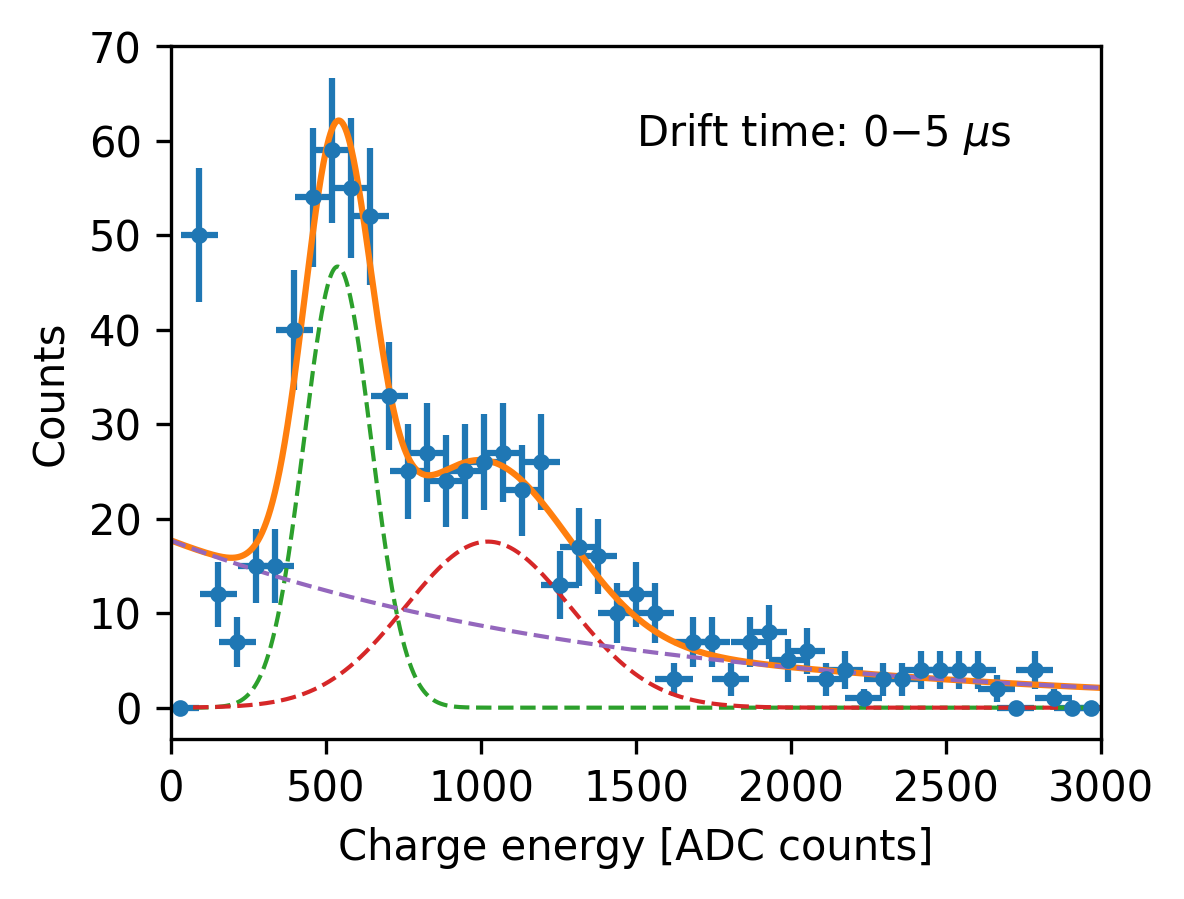

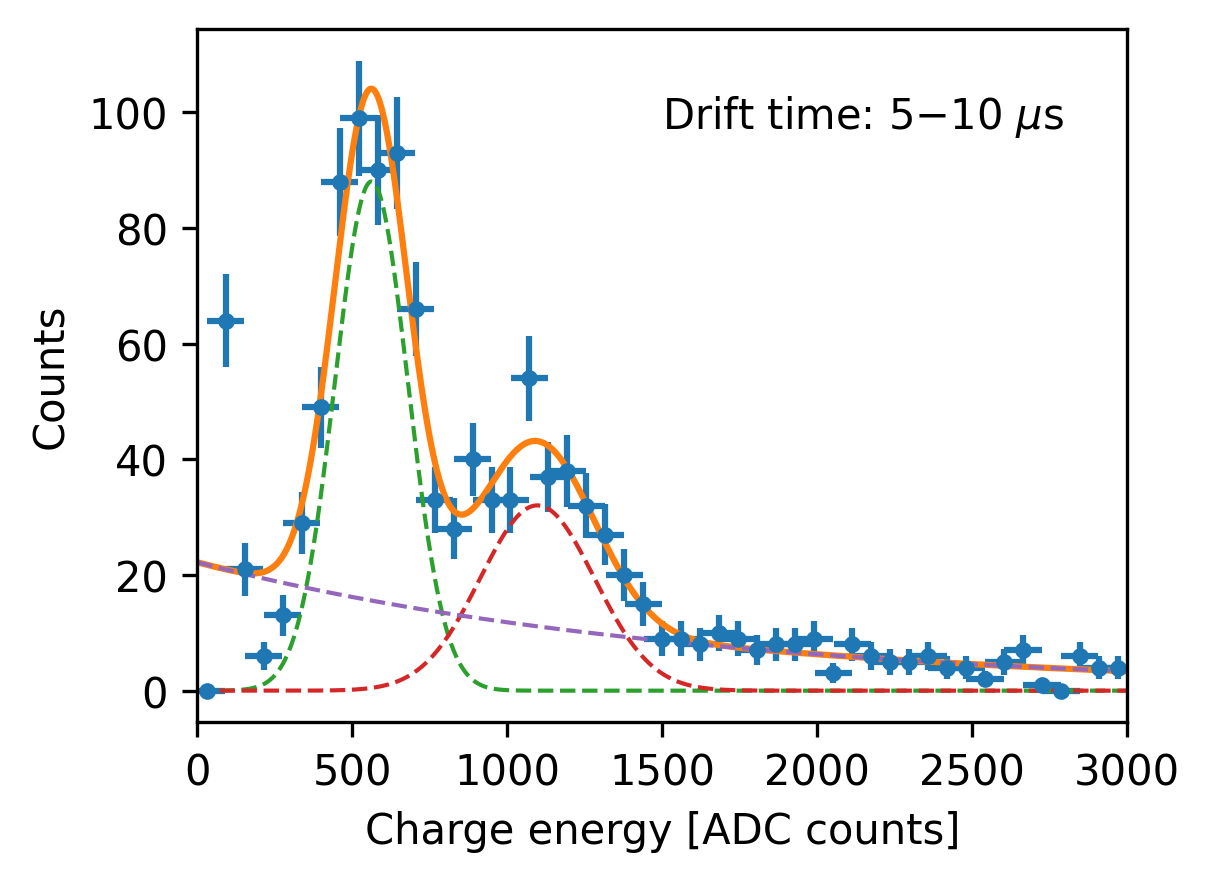

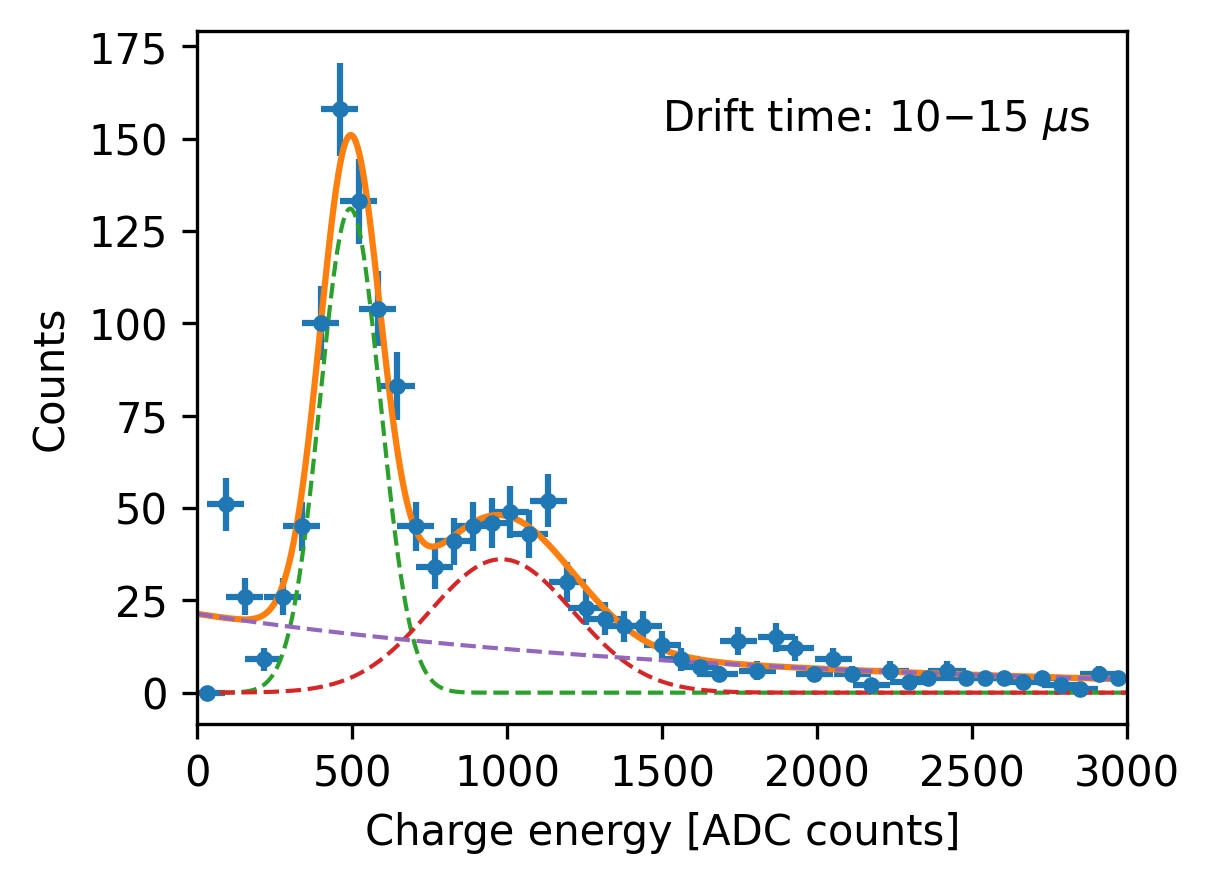

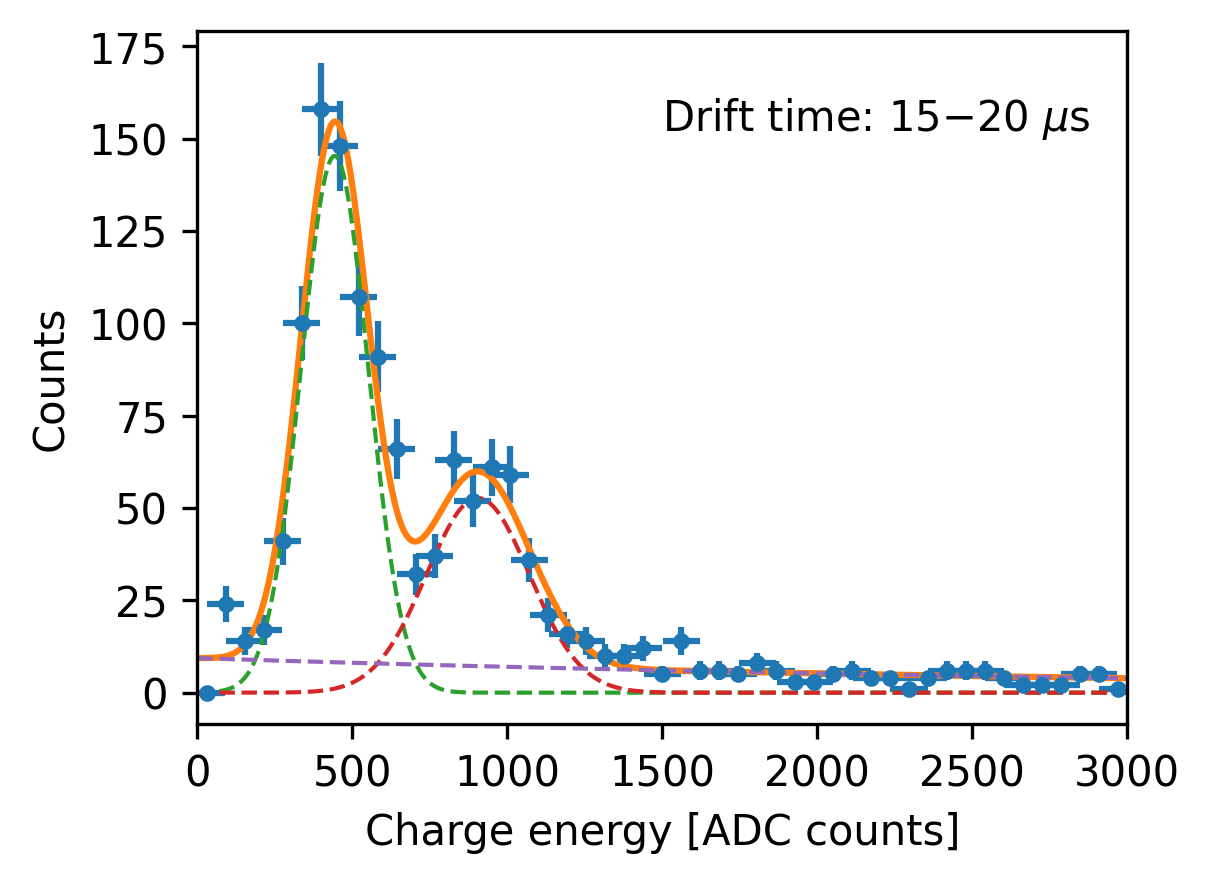

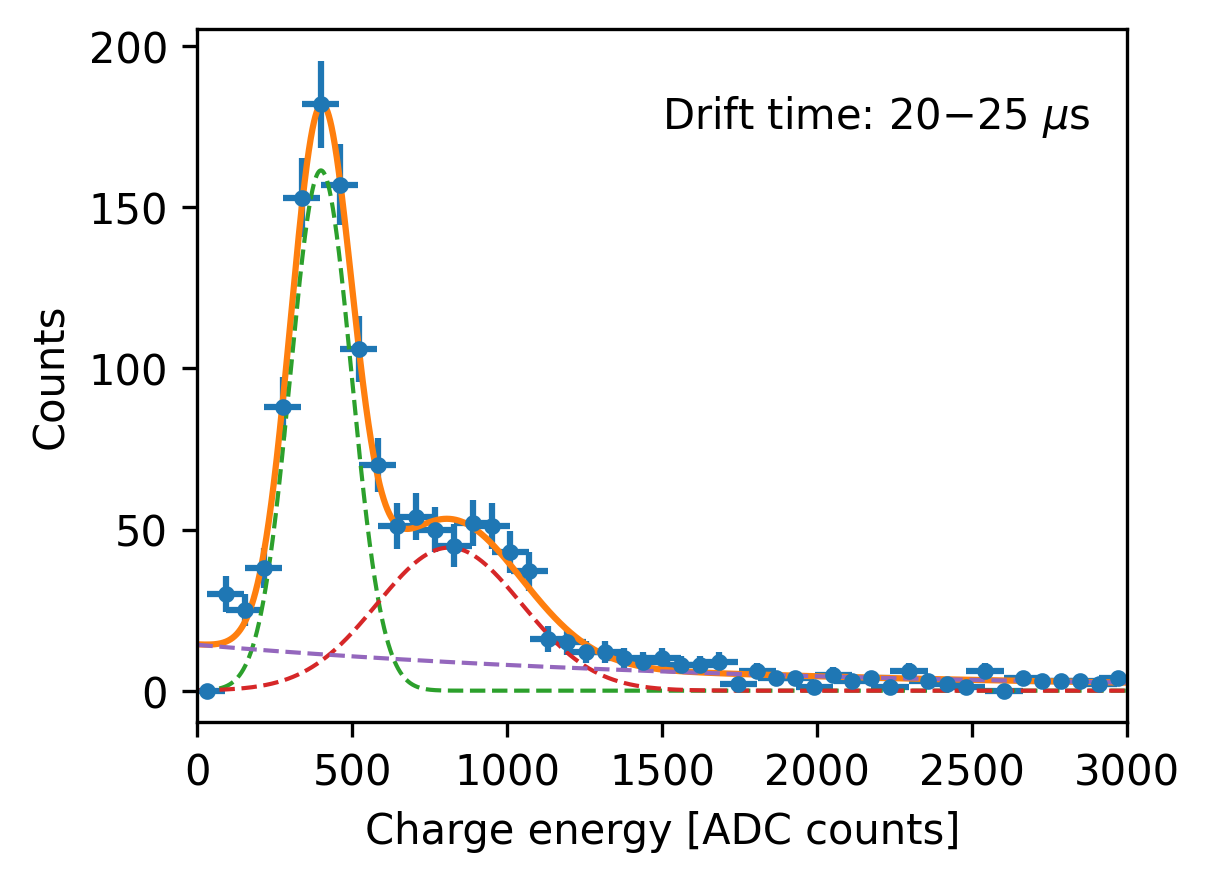

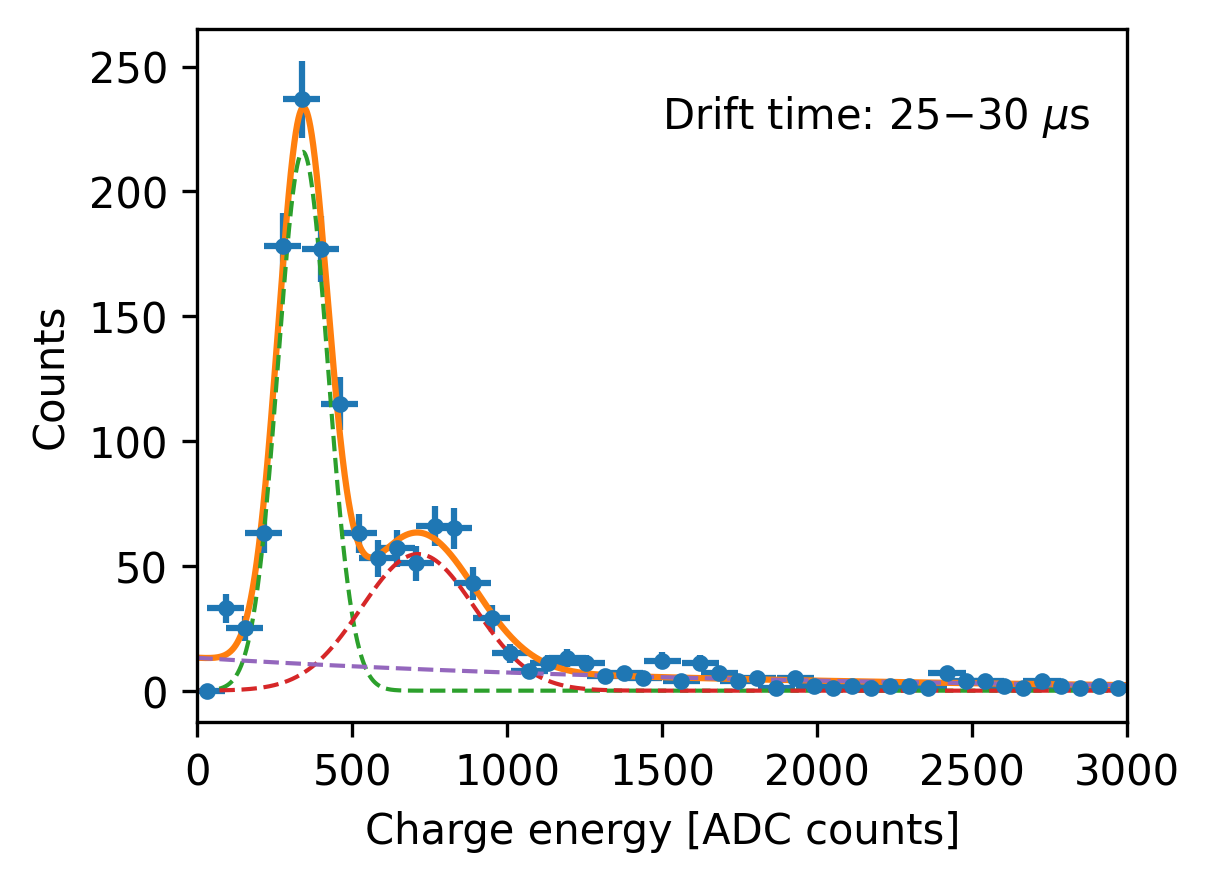

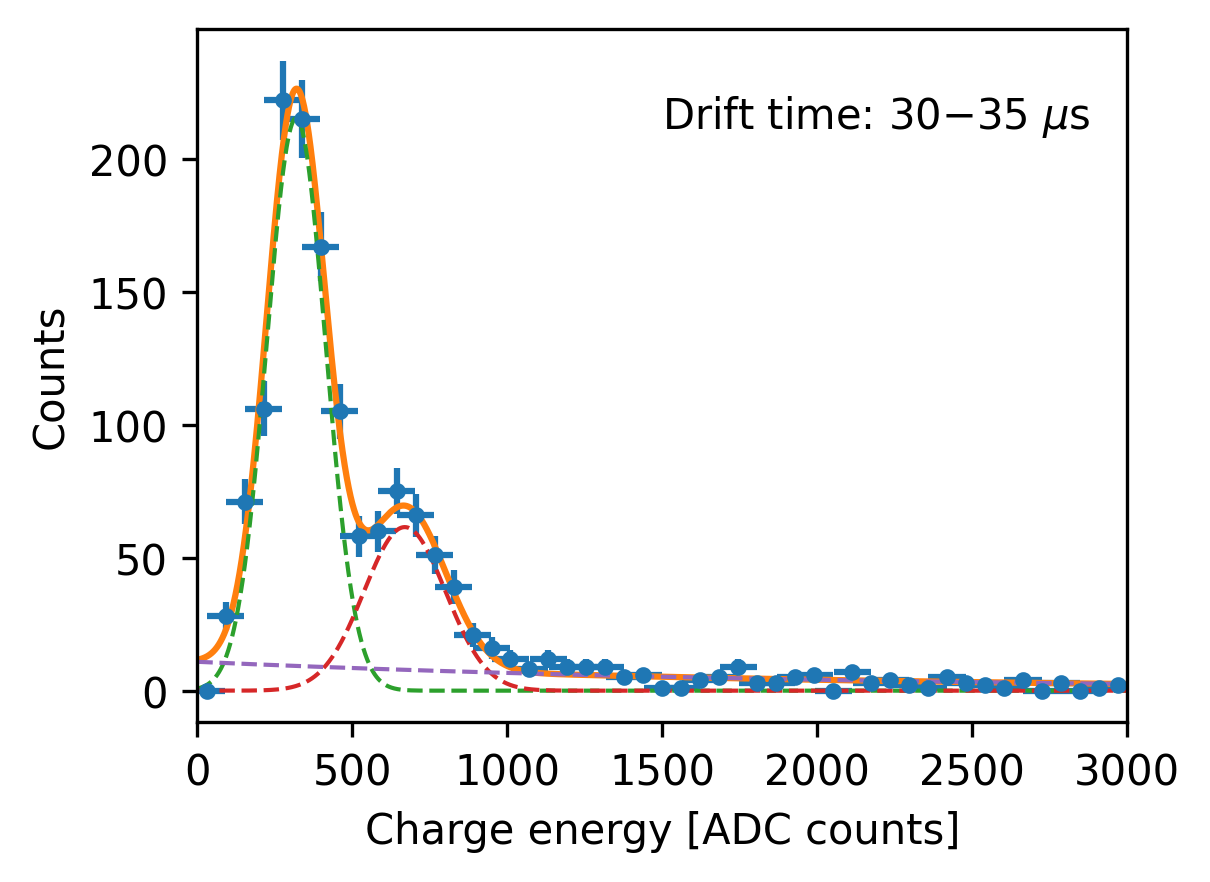

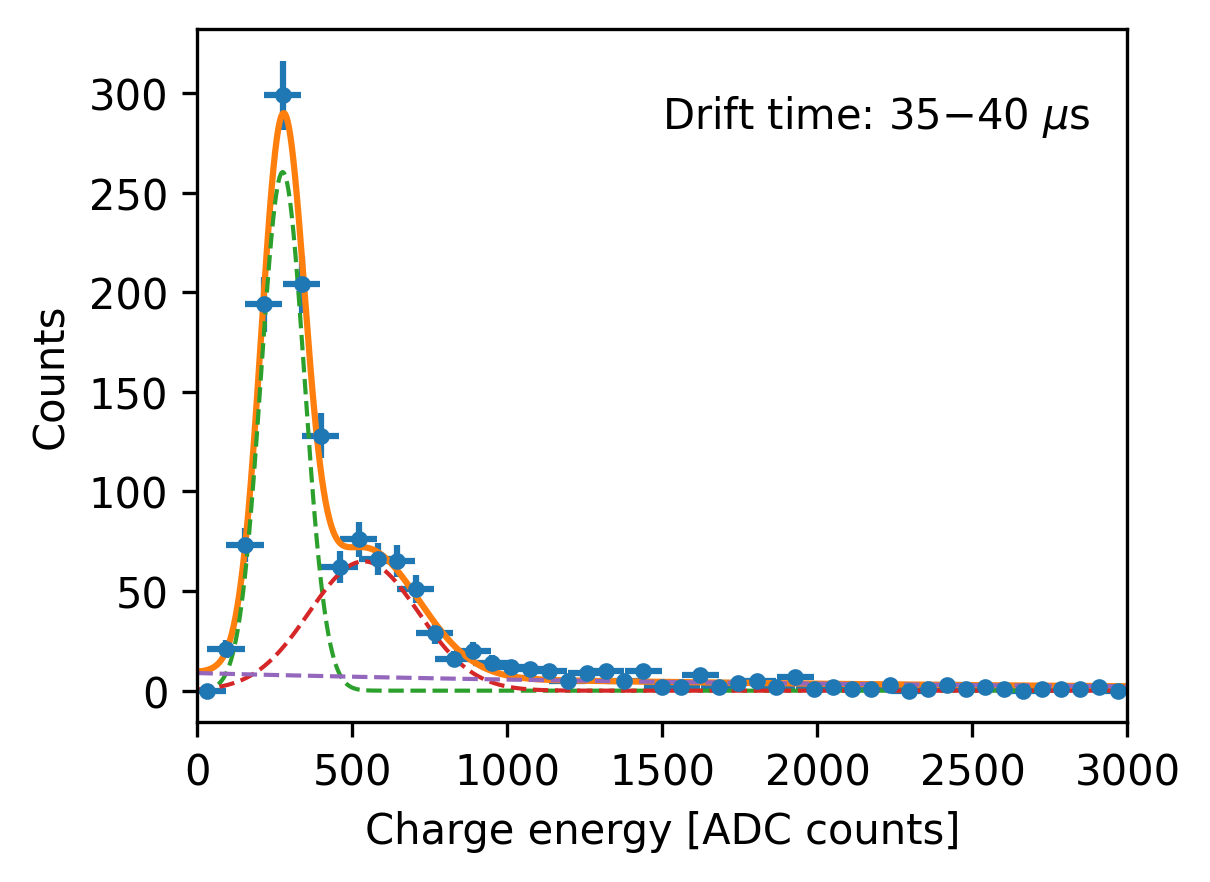

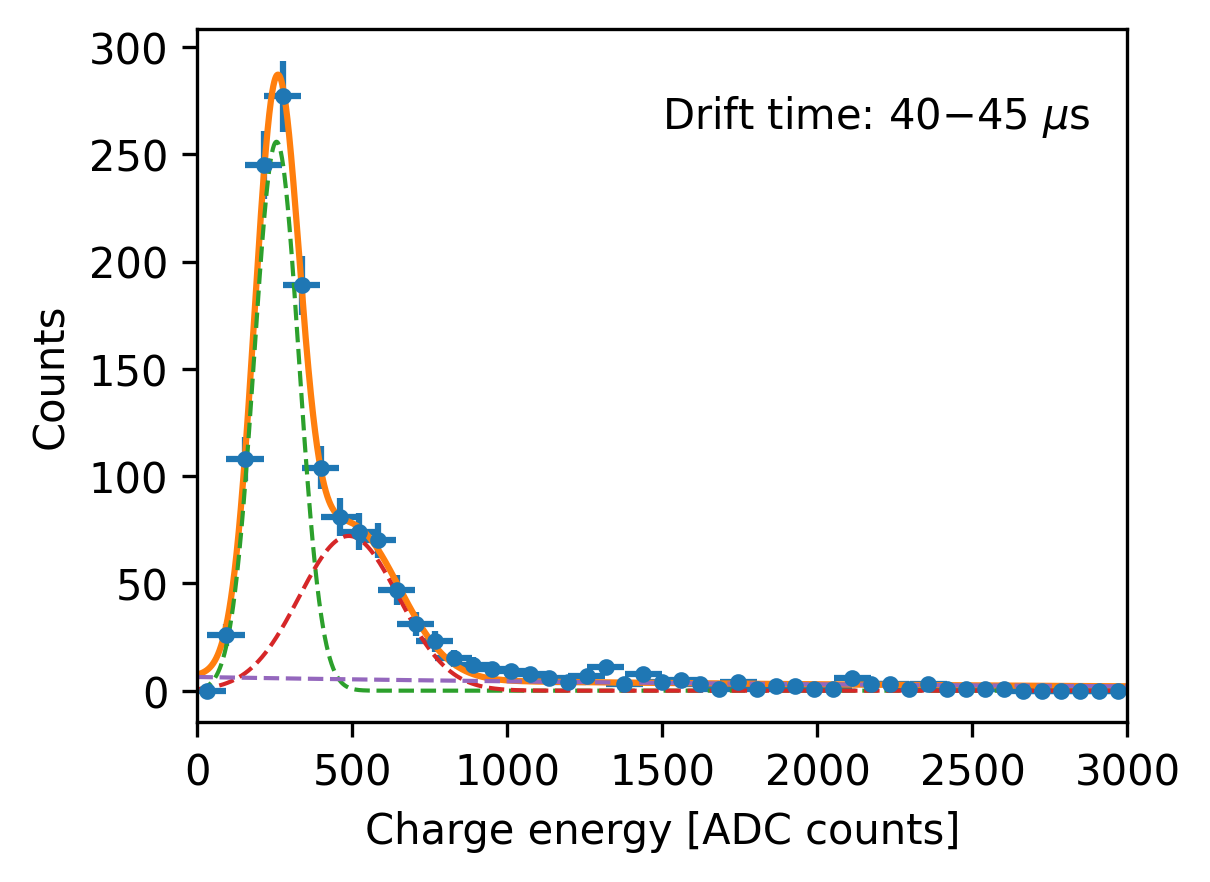

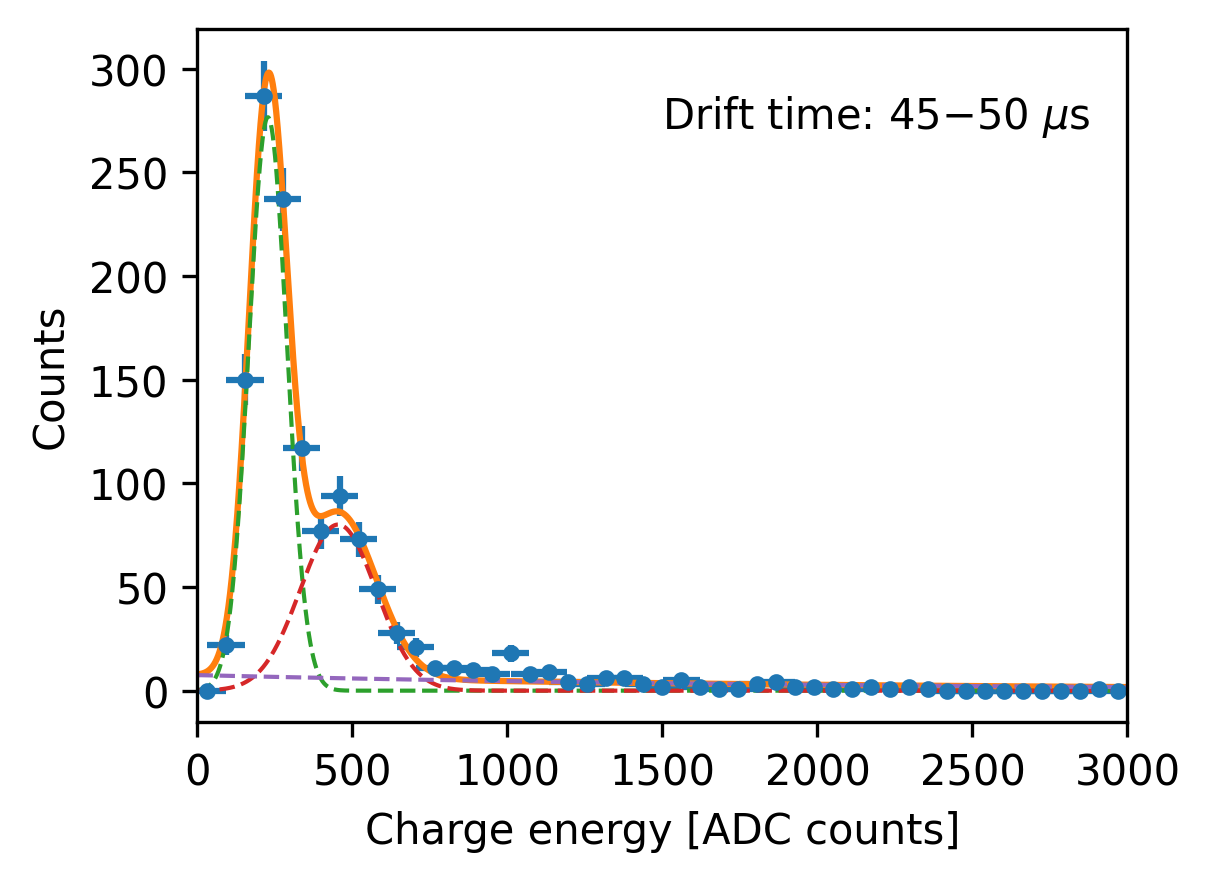

In [6]:
def f(x, a1, a2, b, c, mu1, mu2, sigma1, sigma2):
    return a1*np.exp(-(x-mu1)**2/2./sigma1**2) + a2*np.exp(-(x-mu2)**2/2./sigma2**2) + c*np.exp(-b*x)

drift_time_bins = np.arange(0., 55., 5.)
drift_times = (drift_time_bins[:-1] + drift_time_bins[1:])/2.
mean_low = np.zeros(len(drift_time_bins) - 1)
mean_high = np.zeros(len(drift_time_bins) - 1)
err_low = np.zeros(len(drift_time_bins) - 1)
err_high = np.zeros(len(drift_time_bins) - 1)

for i in range(len(drift_time_bins) - 1):
    this_bin = mask & (data['WeightedDriftTime'].values > drift_time_bins[i]) \
                    & (data['WeightedDriftTime'].values <= drift_time_bins[i + 1])
    these_counts, these_charge_edges = np.histogram(data['TotalTileEnergy'][this_bin].values, bins=np.linspace(0,3000,50))
    this_charge = (these_charge_edges[:-1] + these_charge_edges[1:])/2.
    p0 = [150, 30, 1e-2, 10, this_charge[np.argmax(these_counts)], 2.*this_charge[np.argmax(these_counts)], 20, 20]
    p, c = curve_fit(f, this_charge, these_counts, p0=p0)
    mean_low[i] = p[4]
    mean_high[i] = p[5]
    err_low[i] = np.sqrt(c[4][4])
    err_high[i] = np.sqrt(c[5][5])

    fig, ax = plt.subplots(figsize=(4,3), dpi=300)
    ax.errorbar(this_charge, these_counts, yerr=np.sqrt(these_counts), xerr=3000./50., ls='none', marker='.')
    charge_plot = np.linspace(0.1, 3000, 10000)
    counts_plot = f(charge_plot, *p)
    ax.plot(charge_plot, counts_plot)
    ax.plot(charge_plot, f(charge_plot, p[0], 0, 1, 0, p[4], 1, p[6], 1), lw=1, ls='--')
    ax.plot(charge_plot, f(charge_plot, 0, p[1], 1, 0, 1, p[5], 1, p[7]), lw=1, ls='--')
    ax.plot(charge_plot, f(charge_plot, 0, 0, p[2], p[3], 1, 1, 1, 1), lw=1, ls='--')
    ax.set_xlabel('Charge energy [ADC counts]')
    ax.set_ylabel('Counts')
    ax.set_xlim([0, 3000])
    ax.text(1500, 0.85*ax.get_ylim()[-1], 'Drift time: {:.0f}$-${:.0f} $\mu$s'\
            .format(drift_time_bins[i], drift_time_bins[i + 1]))

### Define the electron lifetime function

In [7]:
v_drift = 1.7 # drift speed, mm/us
n_zsteps = 1000
z_steps = np.linspace(1e-3, 150, n_zsteps)
charge_vs_z = np.zeros(n_zsteps)

for i in range(n_zsteps):
    drift_points, charge_wfm = SignalCalculator.ComputeChargeWaveformOnStripWithIons( \
        1, 1.5, 0, z_steps[i], padSize=3, numPads=30, numWfmPoints=10)
    charge_vs_z[i] = charge_wfm[-1]

def I(t):
    return np.interp(t*v_drift, z_steps, charge_vs_z,)

def Q_e(t, Q_0, tau):
    return I(t)*Q_0*np.exp(-t/tau)

/g/g92/hardy27/CurrentAndChargeSignalCalculator/SignalCalculator/SignalCalculator.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(x*y / (z * np.sqrt(x**2 + y**2 + z**2)))


### Fit the electron lifetime over all drift time bins

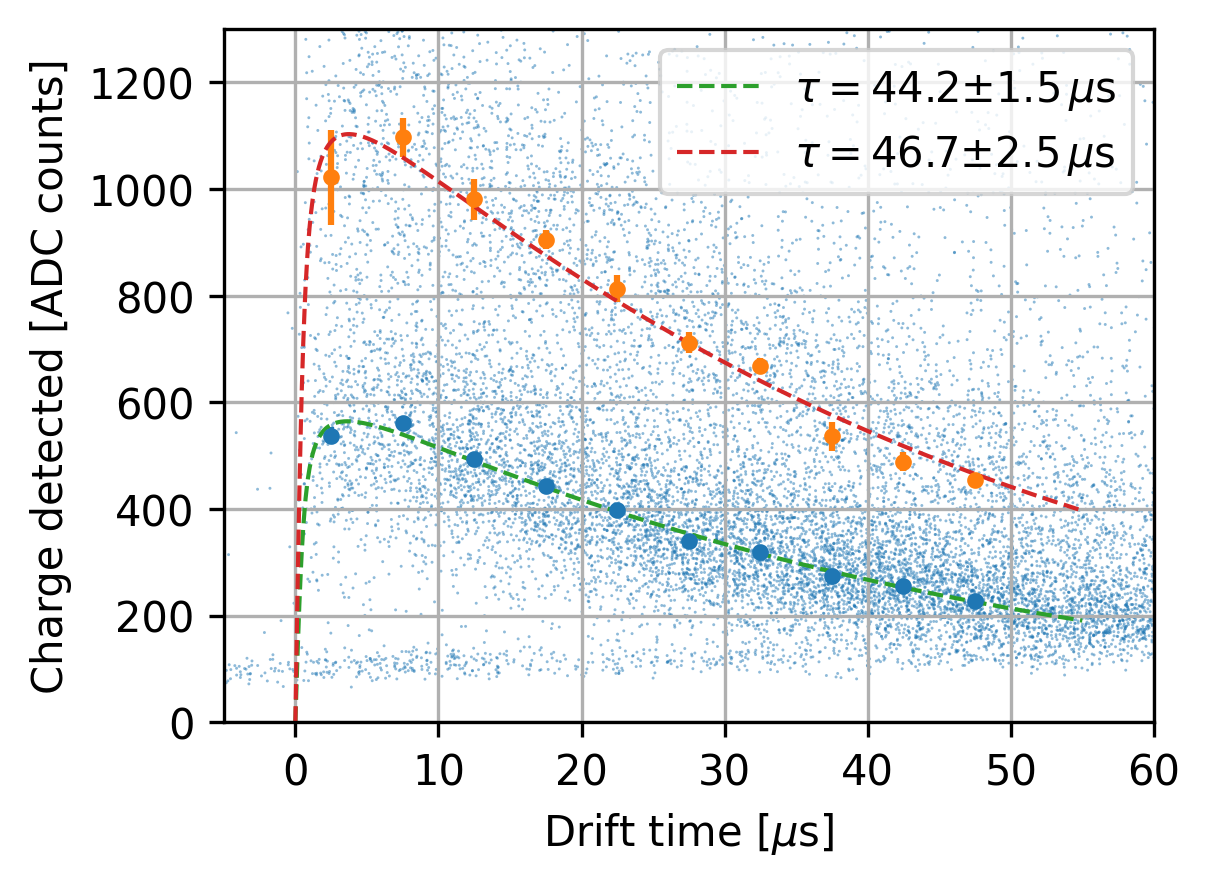

In [8]:
p_low, c_low = curve_fit(Q_e, drift_times, mean_low, p0=[500, 50])
p_high, c_high = curve_fit(Q_e, drift_times, mean_high, p0=[500, 50])

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
plot_drift_times = np.linspace(0, 55, 1000)
ax.scatter(data['WeightedDriftTime'][mask].values, data['TotalTileEnergy'][mask].values, \
           marker='.', edgecolors='none', s=2, alpha=0.5)
ax.errorbar(drift_times, mean_low, yerr=err_low, ls='none', marker='.')
ax.errorbar(drift_times, mean_high, yerr=err_high, ls='none', marker='.')
ax.plot(plot_drift_times, Q_e(plot_drift_times, *p_low), ls='--', lw=1, \
        label='$\\tau=${:.1f}$\pm${:.1f}$\,\mu$s'.format(p_low[1], np.sqrt(c_low[1][1])))
ax.plot(plot_drift_times, Q_e(plot_drift_times, *p_high), ls='--', lw=1, \
        label='$\\tau=${:.1f}$\pm${:.1f}$\,\mu$s'.format(p_high[1], np.sqrt(c_high[1][1])))
ax.set_xlabel('Drift time [$\mu$s]')
ax.set_ylabel('Charge detected [ADC counts]')
ax.set_xlim([-5, 60])
ax.set_ylim([0, 1300])
ax.legend()
ax.grid()

In [40]:
def date_to_timestamp(date_str):
    """Convert YYYYMMDDHHMMSS format string to Unix timestamp
    Args:
        date_str: String in format 'YYYYMMDDHHMMSS'
    Returns:
        Unix timestamp (seconds since Jan 1, 1970)
    """
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:8])
    hour = int(date_str[8:10])
    minute = int(date_str[10:12])
    second = int(date_str[12:14])
    
    # Days in each month (non-leap year)
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    # Adjust February for leap years
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
        days_in_month[1] = 29
    
    # Calculate days since epoch
    days = 0
    for y in range(1970, year):
        if y % 4 == 0 and (y % 100 != 0 or y % 400 == 0):
            days += 366
        else:
            days += 365
            
    # Add days for months in current year
    for m in range(month - 1):
        days += days_in_month[m]
    
    # Add days in current month
    days += day - 1
    
    # Convert everything to seconds
    timestamp = days * 86400  # seconds per day
    timestamp += hour * 3600  # seconds per hour
    timestamp += minute * 60  # seconds per minute
    timestamp += second
    
    return timestamp

times = []
[times.append(date_to_timestamp(data['File'][i][17:31])) for i in range(len(data.index))]
times = np.array(times)

data['unix_timestamps'] = times